##**AI Classification for Detecting Infected Palm Leaves**

**This section of the code primarily focuses on classifying a processed dataset containing 9 different types of infected palm leaves (one of which is healthy). This is later integrated with drones to detect the palm leave using object detection. The main goal for this code is showcasing the accuracy for the dataset provided in other attached files.**

## **1) Unzipping the folder containing datasets of the infected leaves**


The zip file is taken from the one drive. The reason for doing that instead of downloading it manually and directly is that it slows down the process of dowloading. Downloading it directly to the one drive and then unzipping the file is a better approach in terms of speed.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This is subject to change according to what directory you saved the zip file:

In [6]:
!cp /content/drive/MyDrive/Diseases_of_date_palm_leaves_dataset.zip /content/

In [7]:
!unzip /content/Diseases_of_date_palm_leaves_dataset.zip

Archive:  /content/Diseases_of_date_palm_leaves_dataset.zip
replace Diseases of date palm leaves dataset/Infected Date Palm Leaves Dataset/Processed/1. Potassium Deficiency/M9 (101).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## **2) Installing Relevant Dependencies**


In [8]:
!pip install torch torchvision matplotlib seaborn scikit-learn numpy

## **3) Importing Libraries**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import models

# Datasets & Dataloader
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# This is for spliting the data
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# This is for visualization purposes
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

import os # we shall use this to specify the maximum number of workers

# **4) Data Augmentation**

We need to standardize the images into particular size and convert it to tensor as pytorch understands the input as a tensor. Normalizing the data is optional but the data augmentation can either make the accuracy better or not.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# **5) Deriving the full dataset & visualizing the data we're dealing with**

In [11]:
dataset_path = '/content/Diseases of date palm leaves dataset/Infected Date Palm Leaves Dataset/Processed'

full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
indices = list(range(len(full_dataset)))

num_images = len(full_dataset)
num_classes = len(full_dataset.classes)

print(f"Number of classes: {num_classes}")
print(f"Number of Images: {num_images}")
print(f"Class labels: {full_dataset.classes}")

Number of classes: 9
Number of Images: 3089
Class labels: ['1. Potassium Deficiency', '2. Manganese Deficiency', '3. Magnesium Deficiency', '4. Black Scorch', '5. Leaf Spots', '6. Fusarium Wilt', '7. Rachis Blight', '8. Parlatoria Blanchardi', '9. Healthy sample']


# **6) Data Splitting**

We use the known library for splitting our data. We depend on 80% training size and the testing size is 20%.

In [12]:
train_indices, val_indices = train_test_split(indices, test_size=0.2, train_size=0.8, random_state=42)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# **6) DataLoader**

Choosing the batch size was suitable at 32 to avoid overfitting or underfitting of the data.

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# **7) Model**

We used a pretrained model over any sort of customed-made model for not only faster training but also for better accuracy. Nonetheless, since we have stated that we have 9 number of classes that we are dealing with, we shall only change the final layer of the neural network which is the output for classifying those 9 classes. We also depended on Adam optimizer as it gave the best accuracy (Some parameters we have tried such as weight_decay caused some problems, that is why we depended on the default hyperparameters of Adam optimizer).

In [14]:
model = models.resnet18(weights=None)

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **8) Training the Model**

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

################################### Training Accuracy ##########################################################

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        train_acc = correct.double() / total
        train_acc_history.append(train_acc)
        print(f'Training Loss: {running_loss / total:.4f}, Training Accuracy: {train_acc:.4f}')

################################### Validation Accuracy ##########################################################

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels.data)
                val_total += labels.size(0)
                val_loss += loss.item() * inputs.size(0)

        val_acc = val_correct.double() / val_total
        val_acc_history.append(val_acc)
        print(f'Validation Loss: {val_loss / val_total:.4f}, Validation Accuracy: {val_acc:.4f}')

    return train_acc_history, val_acc_history

train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=6)


Epoch 1/6


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training Loss: 1.6442, Training Accuracy: 0.4330
Validation Loss: 1.5964, Validation Accuracy: 0.4369
Epoch 2/6
Training Loss: 1.2636, Training Accuracy: 0.5767
Validation Loss: 1.5802, Validation Accuracy: 0.4935
Epoch 3/6
Training Loss: 1.1916, Training Accuracy: 0.5937
Validation Loss: 1.3824, Validation Accuracy: 0.5113
Epoch 4/6
Training Loss: 1.0409, Training Accuracy: 0.6495
Validation Loss: 1.2834, Validation Accuracy: 0.5631
Epoch 5/6
Training Loss: 1.0410, Training Accuracy: 0.6346
Validation Loss: 1.4906, Validation Accuracy: 0.4935
Epoch 6/6
Training Loss: 0.9650, Training Accuracy: 0.6677
Validation Loss: 1.0433, Validation Accuracy: 0.6424


# **9) Data Visualization**

We display the results of the accuracy for each epoch using the matplot graph, and for further details of the recall, precision and F1 score we use the confusion matrix. Since numpy can't understand tensors, we will convert tensors back to numpy for plotting purposes.

In [16]:
train_acc_cpu = [acc.cpu().numpy() for acc in train_acc]
val_acc_cpu = [acc.cpu().numpy() for acc in val_acc]

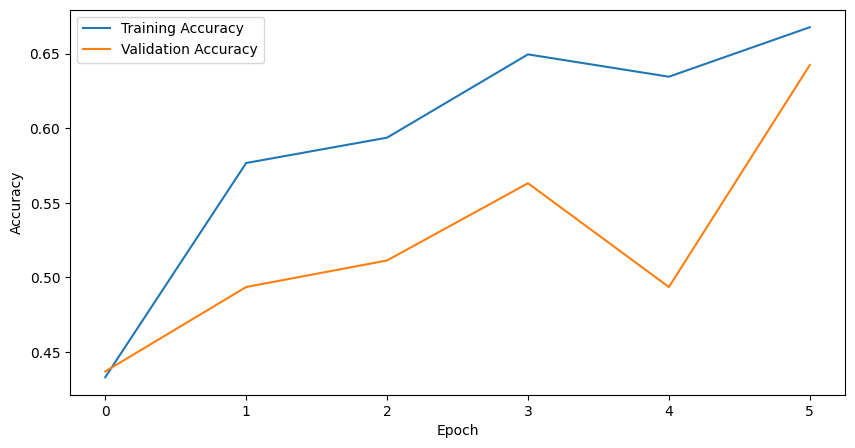

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_cpu, label='Training Accuracy')
plt.plot(val_acc_cpu, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

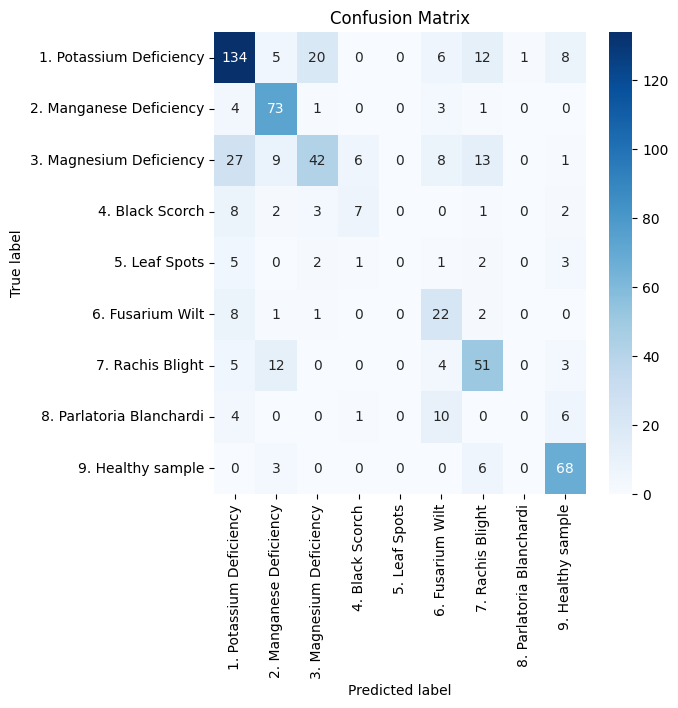

Precision: 0.6067
Recall: 0.6424
F1 Score: 0.6157
                          precision    recall  f1-score   support

 1. Potassium Deficiency       0.69      0.72      0.70       186
 2. Manganese Deficiency       0.70      0.89      0.78        82
 3. Magnesium Deficiency       0.61      0.40      0.48       106
         4. Black Scorch       0.47      0.30      0.37        23
           5. Leaf Spots       0.00      0.00      0.00        14
        6. Fusarium Wilt       0.41      0.65      0.50        34
        7. Rachis Blight       0.58      0.68      0.63        75
8. Parlatoria Blanchardi       0.00      0.00      0.00        21
       9. Healthy sample       0.75      0.88      0.81        77

                accuracy                           0.64       618
               macro avg       0.47      0.50      0.47       618
            weighted avg       0.61      0.64      0.62       618



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [18]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

class_names = full_dataset.classes
plot_confusion_matrix(np.array(all_labels), np.array(all_preds), classes=class_names)

precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)